In [55]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import community
import networkx as nx
import cpnet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from web3 import Web3
warnings.filterwarnings('ignore')

from utils.analysis import filter_date, count_unique_addresses, sum_value

## Read data

| Token | Protocol                              | Contract Address                           | Start Date |
|-------|---------------------------------------|--------------------------------------------|------------|
| LUSD  | [Liquity](https://www.liquity.org/)   | 0x5f98805A4E8be255a32880FDeC7F6728C6568bA0 | 2021-04-05 |
| LQTY  | [Liquity](https://www.liquity.org/)   | 0x6DEA81C8171D0bA574754EF6F8b412F2Ed88c54D | 2021-04-05 |
| AAVE  | [Aave](https://aave.com/)             | 0x7Fc66500c84A76Ad7e9c93437bFc5Ac33E2DDaE9 | 2020-10-02 |
| COMP  | [Compound](https://compound.finance/) | 0xc00e94Cb662C3520282E6f5717214004A7f26888 | 2020-03-04 |
| Dai   | [MakerDAO](https://makerdao.com/)     | 0x6B175474E89094C44Da98b954EedeAC495271d0F | 2019-11-13 |

In [56]:
token_name = 'LUSD'
data_date = '2022-07-12'
start_date = '2021-04-05'
end_date = '2022-07-11'

token_name = 'LQTY'
data_date = '2022-07-12'
start_date = '2021-04-05'
end_date = '2022-07-11'

token_name = 'COMP'
data_date = '2022-07-12'
start_date = '2020-03-13'
end_date = '2022-07-11'

# token_name = 'Dai'
# data_date = '2022-07-12'
# start_date = '2019-11-18'
# end_date = '2022-07-11'

# token_name = 'AAVE'
# data_date = '2022-07-12'
# start_date = '2021-04-05'
# end_date = '2022-07-11'

In [58]:
def read_data(token_name, data_date, start_date, end_date):
    infura_url = 'https://mainnet.infura.io/v3/fc6dbeee65044e24a744ff54fec1718d'

    data_date = datetime.strptime(data_date, '%Y-%m-%d')
    data_date_str = data_date.strftime('%y-%m-%d')

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    start_date_str = start_date.strftime('%y-%m-%d')

    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    end_date_str = end_date.strftime('%y-%m-%d')

    DATA_DIR = f'../Data/{token_name}_{data_date_str}'

    print('Token name: {}'.format(token_name))
    # print('Token genesis date: {}'.format('2021-04-05'))
    print('The last date of the collected data: {}'.format(data_date_str))
    print('Analysis start date: {}'.format(start_date_str))
    print('Analysis end date: {}'.format(end_date_str))

    # Raw transaction date
    dtypes = {'token_address':str, 'from_address':str, 'to_address':str, 'timestamp':str, 'value':np.float64}
    raw_tx = pd.read_csv(f'../Data/{token_name}_{data_date_str}.csv', dtype=dtypes)
    raw_tx['timestamp'] = pd.to_datetime(raw_tx['timestamp'])
    raw_tx = filter_date(raw_tx, start_date=start_date, end_date=end_date)

    # Aggregated transaction date
    dtypes = {'timestamp':str, 'from_address':str, 'to_address':str, 'value':np.float64}
    agg_tx = pd.read_csv(f'{DATA_DIR}/01_agg_tx.csv', dtype=dtypes)
    agg_tx['timestamp'] = pd.to_datetime(agg_tx['timestamp'])
    agg_tx = filter_date(agg_tx, start_date=start_date, end_date=end_date)

    # Network features
    network_fea = pd.read_csv(f'{DATA_DIR}/02_network_fea.csv')
    network_fea['timestamp'] = pd.to_datetime(network_fea['timestamp'])
    network_fea = filter_date(network_fea, start_date=start_date, end_date=end_date)
    network_fea.rename(columns={'significance': 'cp_pvalue'}, inplace=True)
    print('Days: {}'.format(len(network_fea)))

    # Addresses that have been the core nodes
    core_address = pd.read_csv(f'{DATA_DIR}/03_core_address.csv')

    network_fea['address_count'] = raw_tx.groupby('timestamp').apply(count_unique_addresses).reset_index().drop(columns=['level_1'])['address_count']
    network_fea['value_sum'] = agg_tx.groupby('timestamp').apply(sum_value).reset_index().drop(columns=['level_1'])['value_sum']
    network_fea['day'] = network_fea.index

    return network_fea, core_address


network_fea, core_address = read_data(token_name, data_date, start_date, end_date)

Token name: COMP
The last date of the collected data: 22-07-12
Analysis start date: 20-03-13
Analysis end date: 22-07-11
Days: 788


## Analysis & Visualization

In [59]:
# Make dir
SAVE_PATH = '../Figure/'
SAVE_DIR = f"{SAVE_PATH}{token_name}_{start_date}-{end_date}"
if os.path.exists(SAVE_DIR) is False:
    os.makedirs(SAVE_DIR)

In [60]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

LUSD_color1 = '#2f4ed0'
LUSD_color2 = '#30b5ec'

LQTY_color1 = '#f4a236'
LQTY_color2 = '#f6685e'

### Figure 1 - Time Series Plots (daily addresses count / transaction volume)

In [61]:
fig = make_subplots(
    rows=2, 
    cols=1,
    subplot_titles=("Daily Addresses Count", "Daily Transaction Volume (Wei)"),
    horizontal_spacing=0.05, 
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['address_count']),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['value_sum']),
    row=2, col=1
)

fig.update_yaxes(type="log", row=2, col=1)

fig.update_layout(height=800, width=800, showlegend=False)
fig.show()

fig.write_image(f"{SAVE_DIR}/fig1.png")

### Figure 2 - Distribution of CA and EOA

In [63]:
core_address

,address,core_days_cnt
0,0x503828976d22510aad0201ac7ec88293211d23da,191
1,0x3d9819210a31b4961b30ef54be2aed79b9c9cd3b,172
2,0xcffdded873554f362ac02f8fb1f02e5ada10516f,117
3,0x56178a0d5f301baf6cf3e1cd53d9863437345bf9,105
4,0x6cc5f688a315f3dc28a7781717a9a798a59fda7b,104
...,...,...
101819,0x7645a63cf8785aafa63d9732e964d63280f739ec,1
101820,0xd67c5d4f78a760d135c7caf464ea114f804f002c,1
101821,0x9bdd0573390f2f824baf8df5359c2cc795c01810,1
101822,0xc6d1082c6ea0510b351ffa4d6c4e872deaa2673f,1


In [62]:
def get_CA_EOA(core_address):
    infura_url = 'https://mainnet.infura.io/v3/fc6dbeee65044e24a744ff54fec1718d' #args.infura_url
    web3 = Web3(Web3.HTTPProvider(infura_url))

    core_address['type'] = core_address['address'].apply(lambda x: 1 if web3.eth.get_code(Web3.toChecksumAddress(x)).hex()=='0x' else 0)
    core_CA = core_address[core_address['type'] == 0]
    core_EOA = core_address[core_address['type'] == 1]

    CA_str = 'CA ({:.4}%)'.format(100*len(core_CA)/len(core_address))
    EOA_str = 'EOA ({:.4}%)'.format(100*core_EOA.shape[0]/core_address.shape[0])

    print('CA VS EOA: {} ({}) | {} ({})'.format(len(core_CA), CA_str, core_EOA.shape[0], EOA_str))

    return {
        'core_address':core_address[core_address['address'] != '0x0000000000000000000000000000000000000000'], 
        'CA_str': CA_str, 
        'EOA_str': EOA_str
        }

core_address_dict = get_CA_EOA(core_address)
core_address = core_address_dict['core_address']
CA_str = core_address_dict['CA_str']
EOA_str = core_address_dict['EOA_str']
core_address

ProxyError: HTTPSConnectionPool(host='mainnet.infura.io', port=443): Max retries exceeded with url: /v3/fc6dbeee65044e24a744ff54fec1718d (Caused by ProxyError('Cannot connect to proxy.', OSError('Tunnel connection failed: 403 Forbidden')))

In [ ]:
core_CA = core_address[core_address['type']==0]['core_days_cnt']
core_EOA = core_address[core_address['type']==1]['core_days_cnt']

fig = go.Figure()
fig.add_trace(go.Box(y=core_CA, name=CA_str))
fig.add_trace(go.Box(y=core_EOA, name=EOA_str))

fig.update_layout(barmode='stack', height=1500, width=500, showlegend=False)
fig.show()

fig.write_image(f"{SAVE_DIR}/fig2.png")

### Figure 3 - Network Dynamics

In [ ]:
fig = make_subplots(
    rows=3, 
    cols=2,
    subplot_titles=(
        "Number of components", 
        "Giant component size ratio", 
        "Modularity", 
        "Std of degree centrality",
        "Number of core nodes",
        "Avg. degree of core nodes"
    ),
    horizontal_spacing=0.05, 
    vertical_spacing=0.08,
)

# LUSD
fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['num_components'], marker_color=LUSD_color1),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['giant_com_ratio'], marker_color=LUSD_color1),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['modularity'], marker_color=LUSD_color1),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['degree_centrality_std'], marker_color=LUSD_color1),
    row=2, col=2
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['num_core'], marker_color=LUSD_color1),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['avg_core_neighbor'], marker_color=LUSD_color1),
    row=3, col=2
)

# fig.update_yaxes(type="log", row=1, col=1)
# fig.update_yaxes(type="log", row=2, col=2)

fig.update_layout(height=1000, width=1400, showlegend=False)
fig.show()

fig.write_image(f"{SAVE_DIR}/fig3.png")

### Figure 4 - Network feature heatmap

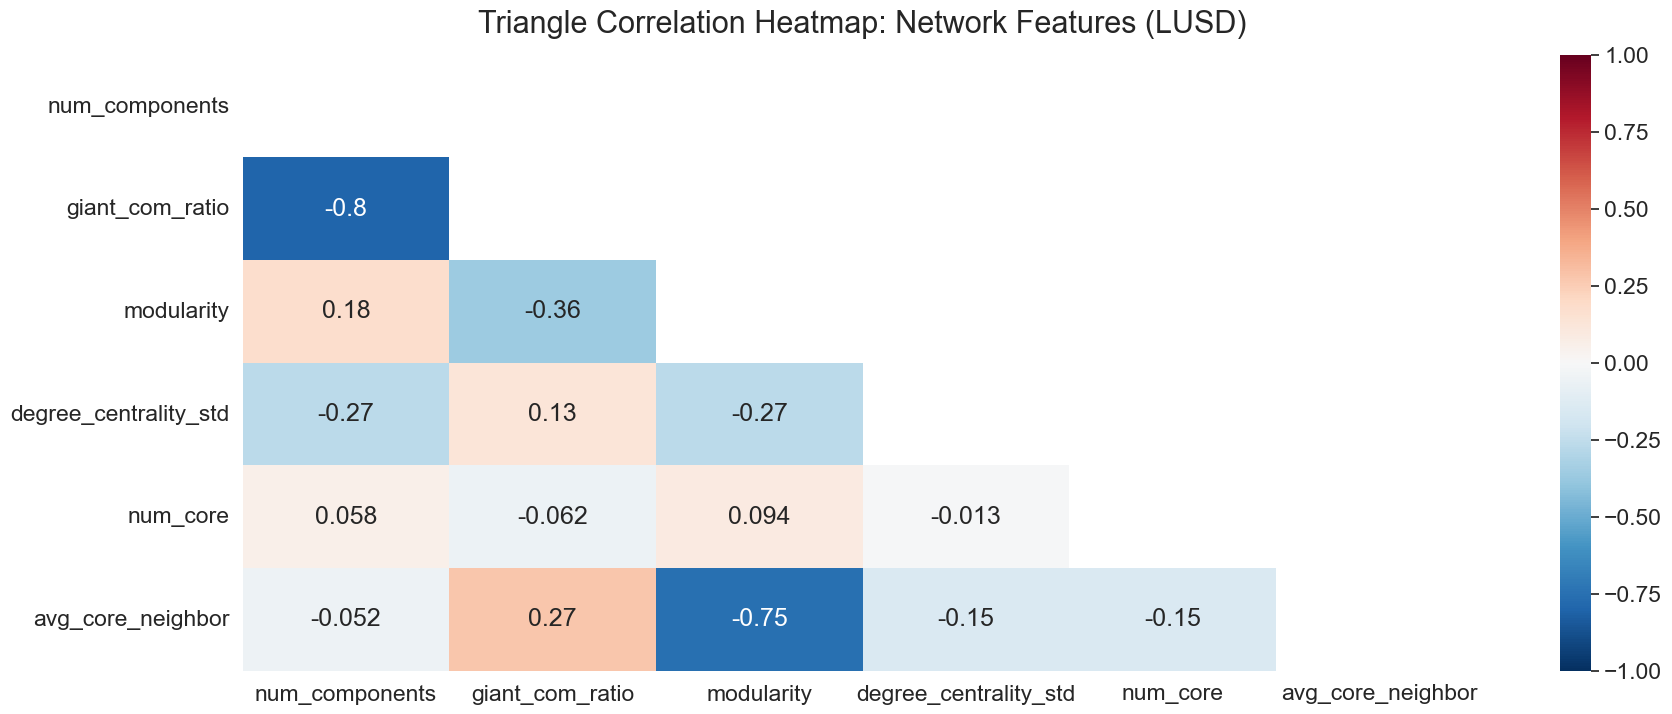

In [ ]:
network_fea_cor = network_fea[['num_components', 'giant_com_ratio', 'modularity', 'degree_centrality_std', 'num_core', 'avg_core_neighbor']].corr()

plt.style.use('default')
plt.figure(figsize=(20, 8))

mask = np.triu(np.ones_like(network_fea_cor, dtype=np.bool))
sns.set(font_scale=1.5) 
heatmap = sns.heatmap(network_fea_cor, mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r')
heatmap.set_title('Triangle Correlation Heatmap: Network Features (LUSD)', fontdict={'fontsize':22}, pad=16);

heatmap.set_facecolor((1,1,1))
plt.savefig(f"{SAVE_DIR}/fig4.png", dpi=100)

### Figure 2

In [53]:
# ======= Figure 2 =======
# Distribution on significant & insignificant days 
LUSD_sig_T = LUSD_network_fea[LUSD_network_fea['cp_pvalue'] < 0.05]
LUSD_sig_F = LUSD_network_fea[LUSD_network_fea['cp_pvalue'] >= 0.05]
LUSD_sig_per = 100*len(LUSD_sig_T)/len(LUSD_network_fea)
LUSD_insig_per = 100*LUSD_sig_F.shape[0]/LUSD_network_fea.shape[0]
print('LUSD > Significant days VS Insignificant days: {} ({:.4}%) | {} ({:.4}%)'.format(len(LUSD_sig_T), LUSD_sig_per, LUSD_sig_F.shape[0], LUSD_insig_per))

LQTY_sig_T = LQTY_network_fea[LQTY_network_fea['cp_pvalue'] < 0.05]
LQTY_sig_F = LQTY_network_fea[LQTY_network_fea['cp_pvalue'] >= 0.05]
LQTY_sig_per = 100*len(LQTY_sig_T)/len(LQTY_network_fea)
LQTY_insig_per = 100*LQTY_sig_F.shape[0]/LQTY_network_fea.shape[0]
print('LQTY > Significant days VS Insignificant days: {} ({:.4}%) | {} ({:.4}%)'.format(len(LQTY_sig_T), LQTY_sig_per, LQTY_sig_F.shape[0], LQTY_insig_per))


fig = go.Figure(data=[
    go.Bar(
        name='Significant', 
        x=['LUSD', 'LQTY'], 
        y=[len(LUSD_sig_T), len(LQTY_sig_T)], 
        text=['Significant ({:.4}%)'.format(LUSD_sig_per), 'Significant ({:.4}%)'.format(LQTY_sig_per)], 
        textposition='inside'
    ),
    go.Bar(
        name='Insignificant', 
        x=['LUSD', 'LQTY'], 
        y=[len(LUSD_sig_F), len(LQTY_sig_F)], 
        text=['Insignificant ({:.4}%)'.format(LUSD_insig_per), 'Insignificant ({:.4}%)'.format(LQTY_insig_per)], 
        textposition='inside'
    )
])
# Change the bar mode
fig.update_layout(barmode='stack', height=400, width=600, showlegend=False)
fig.show()

fig.write_image("../Figure/images/fig2.png")

LUSD > Significant days VS Insignificant days: 335 (72.67%) | 126 (27.33%)
LQTY > Significant days VS Insignificant days: 348 (75.49%) | 113 (24.51%)


### Figure 3

In [54]:
fig = make_subplots(
    rows=2, 
    cols=1,
    subplot_titles=("LUSD: Distribution of core node numbers", "LQTY: Distribution of core node numbers"),
    horizontal_spacing=0.05, 
    vertical_spacing=0.2,
)


LUSD_num_core_sig_T = LUSD_sig_T['num_core']
LUSD_num_core_sig_F = LUSD_sig_F['num_core']

LQTY_num_core_sig_T = LQTY_sig_T['num_core']
LQTY_num_core_sig_F = LQTY_sig_F['num_core']


fig.add_trace(go.Box(x=LUSD_num_core_sig_T, marker_color=LUSD_color1, name="Significant"), row=1, col=1)
fig.add_trace(go.Box(x=LUSD_num_core_sig_F, marker_color=LQTY_color2, name="Insignificant"), row=1, col=1)

fig.add_trace(go.Box(x=LQTY_num_core_sig_T, marker_color=LUSD_color1, name="Significant"), row=2, col=1)
fig.add_trace(go.Box(x=LQTY_num_core_sig_F, marker_color=LQTY_color2, name="Insignificant"), row=2, col=1)

fig.update_layout(barmode='stack', height=500, width=1300, showlegend=False)
fig.show()

fig.write_image("../Figure/images/fig3.png")

### Figure 4

In [55]:
fig = make_subplots(
    rows=2, 
    cols=1,
    subplot_titles=("LUSD: Distribution of average degree of the core nodes", "LQTY: Distribution of average degree of the core nodes"),
    horizontal_spacing=0.05, 
    vertical_spacing=0.2,
)

LUSD_num_core_sig_T = LUSD_sig_T['avg_core_neighbor']
LUSD_num_core_sig_F = LUSD_sig_F['avg_core_neighbor']

LQTY_num_core_sig_T = LQTY_sig_T['avg_core_neighbor']
LQTY_num_core_sig_F = LQTY_sig_F['avg_core_neighbor']


fig.add_trace(go.Box(x=LUSD_num_core_sig_T, marker_color=LUSD_color1, name="Significant"), row=1, col=1)
fig.add_trace(go.Box(x=LUSD_num_core_sig_F, marker_color=LQTY_color2, name="Insignificant"), row=1, col=1)

fig.add_trace(go.Box(x=LQTY_num_core_sig_T, marker_color=LUSD_color1, name="Significant"), row=2, col=1)
fig.add_trace(go.Box(x=LQTY_num_core_sig_F, marker_color=LQTY_color2, name="Insignificant"), row=2, col=1)

fig.update_layout(barmode='stack', height=500, width=1300, showlegend=False)
fig.show()

fig.write_image("../Figure/images/fig4.png")

### Figure 5

In [25]:
def get_CA_EOA(core_address):
    infura_url = 'https://mainnet.infura.io/v3/fc6dbeee65044e24a744ff54fec1718d' #args.infura_url
    web3 = Web3(Web3.HTTPProvider(infura_url))

    core_address['type'] = core_address['address'].apply(lambda x: 1 if web3.eth.get_code(Web3.toChecksumAddress(x)).hex()=='0x' else 0)
    core_CA = core_address[core_address['type'] == 0]
    core_EOA = core_address[core_address['type'] == 1]

    print('CA VS EOA: {} ({:.4}%) | {} ({:.4}%)'.format(len(core_CA), 100*len(core_CA)/len(core_address), core_EOA.shape[0], 100*core_EOA.shape[0]/core_address.shape[0]))

    return core_address

LUSD_core_address = get_CA_EOA(LUSD_core_address)
LQTY_core_address = get_CA_EOA(LQTY_core_address)

CA VS EOA: 112 (29.63%) | 266 (70.37%)
CA VS EOA: 45 (39.13%) | 70 (60.87%)


In [56]:
LUSD_core_address = LUSD_core_address[LUSD_core_address['address'] != '0x0000000000000000000000000000000000000000']
LQTY_core_address = LQTY_core_address[LQTY_core_address['address'] != '0x0000000000000000000000000000000000000000']

LUSD_core_address

,address,core_days_cnt,type
1,0x4f9fbb3f1e99b56e0fe2892e623ed36a76fc605d,409,0
2,0x66017d22b0f8556afdd19fc67041899eb65a21bb,348,0
3,0xed279fdd11ca84beef15af5d39bb4d4bee23f0ca,308,0
4,0x16980c16811bde2b3358c1ce4341541a4c772ec9,271,0
5,0x4e0924d3a751be199c426d52fb1f2337fa96f736,221,0
...,...,...,...
373,0xb0a2c845e5437742fa15c5f89379b03cb3254d22,1,1
374,0x8deab613dea75c61c6b63afad70085b6144e8ee0,1,1
375,0x76720ac2574631530ec8163e4085d6f98513fb27,1,1
376,0x7afb8af080a38daf904a4498bcd6c5f93fa834d6,1,1


In [30]:
fig = make_subplots(
    rows=2, 
    cols=1,
    subplot_titles=("LUSD: Distribution of core node numbers", "LQTY: Distribution of core node numbers"),
    horizontal_spacing=0.05, 
    vertical_spacing=0.2,
)

LUSD_core_CA = LUSD_core_address[LUSD_core_address['type']==0]['core_days_cnt']
LUSD_core_EOA = LUSD_core_address[LUSD_core_address['type']==1]['core_days_cnt']

LQTY_core_CA = LQTY_core_address[LQTY_core_address['type']==0]['core_days_cnt']
LQTY_core_EOA = LQTY_core_address[LQTY_core_address['type']==1]['core_days_cnt']


fig.add_trace(go.Box(x=LUSD_core_CA, marker_color=LUSD_color1, name="CA (29.63%)"), row=1, col=1)
fig.add_trace(go.Box(x=LUSD_core_EOA, marker_color=LQTY_color2, name="EOA (70.37%)"), row=1, col=1)

fig.add_trace(go.Box(x=LQTY_core_CA, marker_color=LUSD_color1, name="CA (39.13%)"), row=2, col=1)
fig.add_trace(go.Box(x=LQTY_core_EOA, marker_color=LQTY_color2, name="EOA (60.87%)"), row=2, col=1)

fig.update_layout(barmode='stack', height=500, width=1400, showlegend=False)
fig.show()

fig.write_image("../Figure/images/fig5.png")

### Figure 6

In [31]:
LUSD_network_fea.columns

Index(['timestamp', 'num_edges', 'num_nodes', 'degree_mean', 'degree_std',
       'top10_degree_mean', 'top10_degree_std', 'top10_degree_ratio',
       'degree_centrality_mean', 'degree_centrality_std', 'modularity',
       'transitivity', 'eigenvector_centrality_mean',
       'eigenvector_centrality_atd', 'closeness_centrality_mean',
       'closeness_centrality_std', 'num_components', 'giant_com_ratio',
       'num_core', 'avg_core_neighbor', 'cp_pvalue', 'address_count',
       'value_sum', 'day'],
      dtype='object')

In [37]:
fig = make_subplots(
    rows=6, 
    cols=2,
    subplot_titles=(
        "LUSD Number of components", 
        "LUSD Giant component size ratio", 
        "LUSD Modularity", 
        "LUSD Std of degree centrality",
        "LUSD p-value of core-periphery test",
        "LUSD Number of core nodes",

        "LQTY Number of components", 
        "LQTY Giant component size ratio", 
        "LQTY Modularity", 
        "LQTY Std of degree centrality",
        "LQTY p-value of core-periphery test",
        "LQTY Number of core nodes",
    ),
    horizontal_spacing=0.05, 
    vertical_spacing=0.05,
)

# LUSD
fig.add_trace(
    go.Scatter(x=LUSD_network_fea['timestamp'], y=LUSD_network_fea['num_components'], marker_color=LUSD_color1),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=LUSD_network_fea['timestamp'], y=LUSD_network_fea['giant_com_ratio'], marker_color=LUSD_color1),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=LUSD_network_fea['timestamp'], y=LUSD_network_fea['modularity'], marker_color=LUSD_color1),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=LUSD_network_fea['timestamp'], y=LUSD_network_fea['degree_centrality_std'], marker_color=LUSD_color1),
    row=4, col=1
)

fig.add_trace(
    go.Scatter(x=LUSD_network_fea['timestamp'], y=LUSD_network_fea['cp_pvalue'], marker_color=LUSD_color1),
    row=5, col=1
)

fig.add_trace(
    go.Scatter(x=LUSD_network_fea['timestamp'], y=LUSD_network_fea['num_core'], marker_color=LUSD_color1),
    row=6, col=1
)

# LQTY
fig.add_trace(
    go.Scatter(x=LQTY_network_fea['timestamp'], y=LQTY_network_fea['num_components'], marker_color=LQTY_color2),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=LQTY_network_fea['timestamp'], y=LQTY_network_fea['giant_com_ratio'], marker_color=LQTY_color2),
    row=2, col=2
)

fig.add_trace(
    go.Scatter(x=LQTY_network_fea['timestamp'], y=LQTY_network_fea['modularity'], marker_color=LQTY_color2),
    row=3, col=2
)

fig.add_trace(
    go.Scatter(x=LQTY_network_fea['timestamp'], y=LQTY_network_fea['degree_centrality_std'], marker_color=LQTY_color2),
    row=4, col=2
)

fig.add_trace(
    go.Scatter(x=LQTY_network_fea['timestamp'], y=LQTY_network_fea['cp_pvalue'], marker_color=LQTY_color2),
    row=5, col=2
)

fig.add_trace(
    go.Scatter(x=LQTY_network_fea['timestamp'], y=LQTY_network_fea['num_core'], marker_color=LQTY_color2),
    row=6, col=2
)

# fig.update_yaxes(type="log", row=1, col=2)
# fig.update_yaxes(type="log", row=2, col=2)

fig.update_layout(height=1600, width=1400, showlegend=False)
fig.show()

fig.write_image("../Figure/images/fig6.png")

### Figure 7 & 8

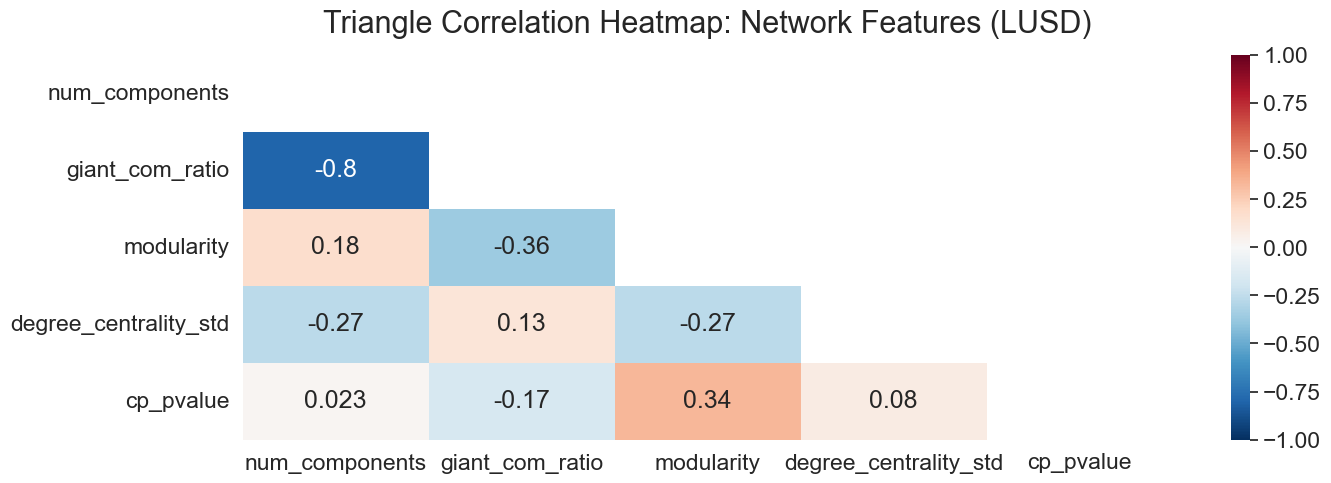

In [45]:
network_fea_cor = LUSD_network_fea[['num_components', 'giant_com_ratio', 'modularity', 'degree_centrality_std', 'cp_pvalue']].corr()

plt.style.use('default')
plt.figure(figsize=(15, 5))

mask = np.triu(np.ones_like(network_fea_cor, dtype=np.bool))
sns.set(font_scale=1.5) 
heatmap = sns.heatmap(network_fea_cor, mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r')
heatmap.set_title('Triangle Correlation Heatmap: Network Features (LUSD)', fontdict={'fontsize':22}, pad=16);

heatmap.set_facecolor((1,1,1))
plt.savefig("../Figure/images/fig7.png", dpi=100)

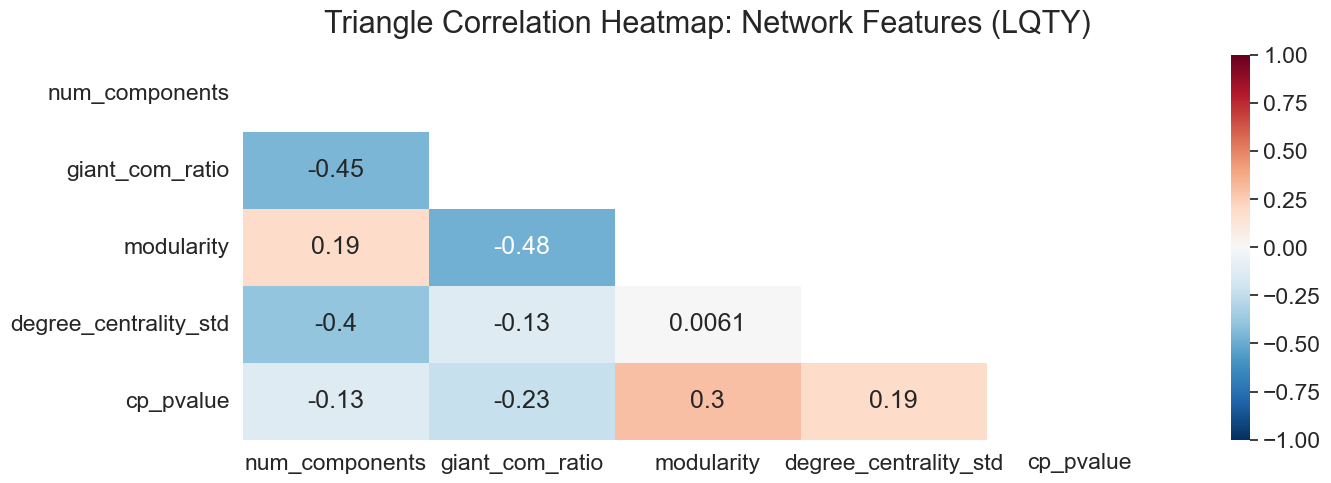

In [46]:
network_fea_cor = LQTY_network_fea[['num_components', 'giant_com_ratio', 'modularity', 'degree_centrality_std', 'cp_pvalue']].corr()

plt.style.use('default')
plt.figure(figsize=(15, 5))

mask = np.triu(np.ones_like(network_fea_cor, dtype=np.bool))
sns.set(font_scale=1.5) 
heatmap = sns.heatmap(network_fea_cor, mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r')
heatmap.set_title('Triangle Correlation Heatmap: Network Features (LQTY)', fontdict={'fontsize':22}, pad=16);

heatmap.set_facecolor((1,1,1))
plt.savefig("../Figure/images/fig8.png", dpi=100)